In [37]:
import os, sys
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path_to_file= r"/workspaces/project-final/vietnam_housing_dataset.csv"
vietnam_housing = pd.read_csv(r"/workspaces/project-final/vietnam_housing_dataset.csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage','Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

## Chia dữ liệu


In [38]:
from sklearn.model_selection import train_test_split
seed = 42
index_all = np.arange(vietnam_housing.shape[0])
index_train, index_test = train_test_split(index_all, test_size=0.33, random_state=seed)

In [39]:
vietnam_housing_train = vietnam_housing.iloc[index_train]
vietnam_housing_test  = vietnam_housing.iloc[index_test]
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [40]:
# Lưu dữ liệu sau khi chia
import os
from pathlib import Path
# define experiment directory (change if you prefer another path)
exps_dir = Path("./exps")
(exps_dir / "data").mkdir(parents=True, exist_ok=True)
vietnam_housing_train.to_excel(f'{exps_dir}/data/train.xlsx', index=None)
vietnam_housing_test.to_excel(f'{exps_dir}/data/test.xlsx', index=None)
np.savez(f'{exps_dir}/data/idx.npz', id_train = index_train, id_test = index_test)


In [41]:
pd.read_excel(f'{exps_dir}/data/train.xlsx')

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Đường Ngọc Lâm, Phường Bồ Đề, Long Biên, Hà Nội",44.6,NaN,NaN,NaN,NaN,6.0,3.0,4.0,Have certificate,Full,9.35
1,"Đường Thế Lữ, Phường An Hải Bắc, Sơn Trà, Đà ...",94.6,4.3,5.5,Đông - Nam,NaN,3.0,3.0,3.0,Have certificate,NaN,5.30
2,"358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...",71.4,4.0,6.0,Nam,Nam,4.0,4.0,3.0,Have certificate,Full,5.95
3,"Đường Định Công Thượng, Phường Định Công, Hoàn...",50.0,4.0,NaN,NaN,NaN,5.0,4.0,4.0,Have certificate,Full,7.05
4,"Đường Số 6, Phường Linh Tây, Thủ Đức, Hồ Chí Minh",74.0,4.0,10.0,Tây - Bắc,Tây - Bắc,3.0,4.0,4.0,Have certificate,NaN,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...
20248,"Đường Lê Văn Thọ, Phường 16, Gò Vấp, Hồ Chí Minh",75.0,4.0,6.0,Đông - Bắc,Đông - Bắc,2.0,3.0,3.0,Have certificate,Full,6.50
20249,"Xã Tân Bình, Vĩnh Cửu, Đồng Nai",105.0,7.0,7.0,NaN,NaN,2.0,4.0,3.0,Have certificate,Full,1.70
20250,"Đường Cầu Diễn, Phường Cầu Diễn, Nam Từ Liêm, ...",34.0,NaN,NaN,NaN,NaN,5.0,5.0,NaN,Have certificate,Basic,5.25
20251,"Đường Nguyễn Phẩm, Phường Hòa Cường Bắc, Hải C...",82.5,5.5,5.5,Tây - Nam,NaN,NaN,2.0,NaN,Have certificate,NaN,5.20


## Tiền xử lý dữ liệu

In [42]:
# create explicit copies of the splits
vietnam_housing_train = vietnam_housing.iloc[index_train].copy()
vietnam_housing_test  = vietnam_housing.iloc[index_test].copy()
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [43]:
vietnam_housing_train.isna().any()

Address              False
Area                 False
Frontage              True
Access Road           True
House direction       True
Balcony direction     True
Floors                True
Bedrooms              True
Bathrooms             True
Legal status          True
Furniture state       True
Price                False
dtype: bool

In [44]:
vietnam_housing_train.dropna(inplace=True)

In [45]:
vietnam_housing_train.drop_duplicates(inplace=True)

In [46]:
# Safe NA fill: tìm biến với khoảng trắng hoặc gạch dưới trước khi fillna
vietnam_housing_train = vietnam_housing_train.copy()

def colname(df, name):
    for cand in (name, name.replace(' ', '_'), name.lower().replace(' ', '_')):
        if cand in df.columns:
            return cand
    return None

for src in ['Frontage','Access Road','Floors','Bedrooms','Bathrooms','Area','Price']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna(vietnam_housing_train[c].median())
    else:
        print(f"Warning: numeric column not found: {src}")

for src in ['House direction','Balcony direction','Legal status','Furniture state','Address']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna('Unknown')
    else:
        print(f"Warning: categorical column not found: {src}")
# ...existing code...

In [47]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing_train.drop_duplicates(inplace=True)
vietnam_housing_train.describe()

,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Price
count,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000
mean,69.407621,5.445282,7.536077,3.232807,3.446449,3.350620,5.433754
std,48.324289,4.892505,7.355552,1.275137,1.166464,1.334584,2.206779
min,3.100000,1.000000,1.300000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.700000
50%,60.000000,4.500000,5.000000,3.000000,3.000000,3.000000,5.200000
75%,81.075000,5.000000,8.000000,4.000000,4.000000,4.000000,7.137500
max,501.000000,69.000000,85.000000,7.000000,9.000000,9.000000,10.000000


## Chuẩn hóa dữ liệu

In [56]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing_train = pd.DataFrame(vietnam_housing_train)
vietnam_housing_clean = vietnam_housing_train.copy()

def find_col(df, name):
    for cand in (name, name.replace(' ', '_'), name.replace(' ', '_').lower()):
        if cand in df.columns:
            return cand
    return None

# Hàm mã hóa hướng an toàn (tạo cột sin/cos với tên có gạch dưới)
def encode_direction(df, name):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    col = find_col(df, name)
    out_base = name.replace(' ', '_')
    if col is None:
        print(f"Warning: direction column not found: {name} -> creating default {out_base}_sin/{out_base}_cos")
        df[out_base + '_sin'] = 0.0
        df[out_base + '_cos'] = 1.0
        return df
    angles = df[col].map(angle_map).fillna(0).astype(float)
    df[out_base + '_sin'] = np.sin(np.deg2rad(angles))
    df[out_base + '_cos'] = np.cos(np.deg2rad(angles))
    return df

# Mã hóa hướng nhà & ban công -
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'House direction')
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'Balcony direction')

# Mã hóa CÁC BIẾN PHÂN LOẠI KHÁC phân loại khác 
# --- Mã hóa các biến phân loại khác ---
for src in ['Legal status', 'Furniture state']:
    col = find_col(vietnam_housing_clean, src)
    out_col = src.replace(' ', '_')
    if col:
        le = LabelEncoder()
        vietnam_housing_clean[out_col] = le.fit_transform(vietnam_housing_clean[col].astype(str))
    else:
        print(f" Warning: categorical column not found: {src}")

# --- One-Hot Encoding (sử dụng cột mới có dấu gạch dưới) ---
vietnam_housing_clean = pd.get_dummies(
    vietnam_housing_clean,
    columns=['Legal_status', 'Furniture_state'],
    drop_first=True
)

In [57]:
# Chuẩn hóa dữ liệu số
cols_to_scale = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
scaler = StandardScaler()

vietnam_housing_clean[cols_to_scale] = scaler.fit_transform(vietnam_housing_clean[cols_to_scale])

# Kiểm tra kết quả
print("Dữ liệu sau khi mã hóa & chuẩn hóa:")
print(vietnam_housing_clean[[
    'Address', 'Area', 'Frontage', 'Access Road', 'House direction',
    'Balcony direction', 'Floors', 'Bedrooms', 'Bathrooms', 'Price',
    'House_direction_sin', 'House_direction_cos',
    'Balcony_direction_sin', 'Balcony_direction_cos',
    'Legal_status_1', 
    'Furniture_state_1', 
]].head())

print("Mean sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].mean().round(2))

print("Std sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].std().round(2))


Dữ liệu sau khi mã hóa & chuẩn hóa:
                                                 Address      Area  Frontage  \
27565  358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...  0.041241 -0.295491   
18669  68, Đường Phan Phú Tiên, Phường Thanh Khê Tây,...  0.074360 -0.091039   
20241  Đường Bình Nhâm, Phường Bình Nhâm, Thuận An, B...  0.695341  0.317865   
3572      Đường Cầu Đơ 4, Phường Hà Cầu, Hà Đông, Hà Nội -0.608719 -0.295491   
921    Đường Thạnh Xuân 24, Phường Thạnh Xuân, Quận 1... -0.236130 -0.295491   

       Access Road House direction Balcony direction  Floors  Bedrooms  \
27565    -0.208891             Nam               Nam     4.0  0.474689   
18669    -0.276886       Tây - Nam         Tây - Nam     4.0  0.474689   
20241    -0.480871       Tây - Bắc         Tây - Bắc     1.0 -1.240378   
3572     -0.480871       Tây - Nam         Tây - Nam     4.0  0.474689   
921      -0.344881      Đông - Nam        Đông - Nam     3.0 -0.382845   

       Bathrooms     Price  House_dire

<Axes: title={'center': 'Boxplot sau khi chuẩn hóa (StandardScaler)'}>

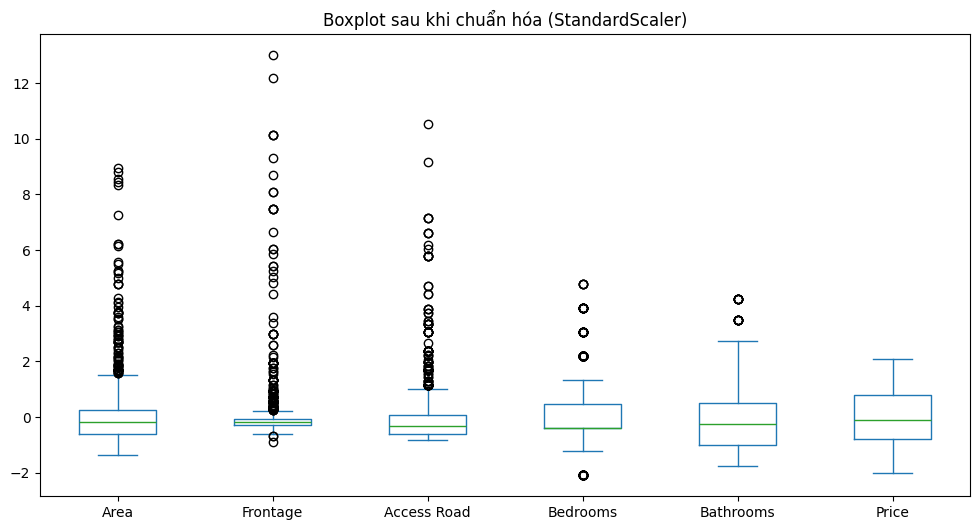

In [58]:
# Vẽ Boxplot sau khi chuẩn hóa
vietnam_housing_clean[cols_to_scale].plot(kind="box", figsize=(12,6), title="Boxplot sau khi chuẩn hóa (StandardScaler)")

Trước / Sau: 1774 / 1346


<Axes: title={'center': 'Boxplot sau khi loại Outlier (IQR)'}>

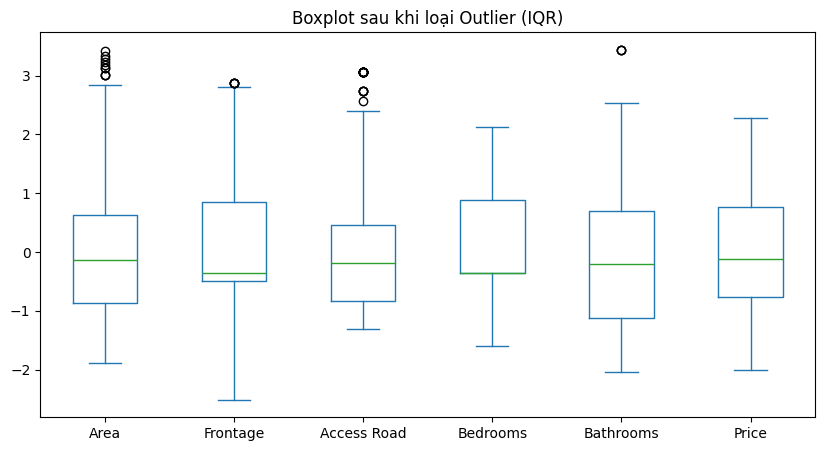

In [59]:
cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms']

mask = np.ones(len(vietnam_housing_clean), bool)
for c in cols:
    q1, q3 = vietnam_housing_clean[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask &= (vietnam_housing_clean[c] >= q1 - 1.5*iqr) & (vietnam_housing_clean[c] <= q3 + 1.5*iqr)

vietnam_housing_clean = vietnam_housing_clean[mask].copy()
print("Trước / Sau:", len(mask), "/", len(vietnam_housing_clean))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms','Price']
vietnam_housing_clean[scale_cols] = scaler.fit_transform(vietnam_housing_clean[scale_cols])

vietnam_housing_clean[scale_cols].plot(kind='box', figsize=(10,5),
    title='Boxplot sau khi loại Outlier (IQR)')


In [60]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms',
        'Price'], dtype=object),
 'n_features_in_': 6,
 'n_samples_seen_': np.int64(1346),
 'mean_': array([-0.22722484, -0.22049658, -0.2673386 , -0.13819918, -0.08961507,
        -0.10222072]),
 'var_': array([0.25662883, 0.0230391 , 0.17622945, 0.47883235, 0.67409157,
        0.90098916]),
 'scale_': array([0.50658546, 0.15178636, 0.41979692, 0.69197713, 0.8210308 ,
        0.94920449])}

In [61]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


,Frontage,Access Road
count,1.346000e+03,1.346000e+03
mean,1.108573e-16,-1.319730e-17
std,1.000372e+00,1.000372e+00
min,-2.514534e+00,-1.318513e+00
25%,-4.940764e-01,-8.325996e-01
50%,-3.593792e-01,-1.847146e-01
75%,8.528952e-01,4.631704e-01
max,2.873353e+00,3.054710e+00


In [62]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


,Frontage,Access Road
count,1.346000e+03,1.346000e+03
mean,1.108573e-16,-1.319730e-17
std,1.000372e+00,1.000372e+00
min,-2.514534e+00,-1.318513e+00
25%,-4.940764e-01,-8.325996e-01
50%,-3.593792e-01,-1.847146e-01
75%,8.528952e-01,4.631704e-01
max,2.873353e+00,3.054710e+00


# THỐNG KÊ MÔ TẢ

In [ ]:
from IPython.display import display  

print("Kích thước dữ liệu:", vietnam_housing_clean.shape)
print("\n== Thông tin cột ==")
display(pd.DataFrame({
    "dtype": vietnam_housing_clean.dtypes.astype(str),
    "missing": vietnam_housing_clean.isna().sum(),
    "missing_rate": (vietnam_housing_clean.isna().mean()*100).round(2).astype(str) + "%"
}).sort_index())

In [ ]:
#Thống kê mô tả cho biến số
num_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n== Thống kê biến số ({len(num_cols)} cột) ==")
display(vietnam_housing_clean[num_cols].describe().T)

In [ ]:
#Thống kê cho biến phân loại (nếu còn)
cat_cols = vietnam_housing_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    print(f"\n== Thống kê biến phân loại ({len(cat_cols)} cột) ==")
    def cat_summary(s: pd.Series):
        vc = s.value_counts(dropna=False)
        return pd.Series({
            "n_unique": s.nunique(dropna=False),
            "top": vc.index[0],
            "top_freq": int(vc.iloc[0]),
            "top_freq_rate": f"{(vc.iloc[0]/len(s)*100):.2f}%"
        })
    display(pd.DataFrame({c: cat_summary(vietnam_housing_clean[c]) for c in cat_cols}).T)
else:
    print("\n== Không còn biến phân loại ==")

In [ ]:
#Ma trận tương quan nhanh
print("\n== Tương quan giữa các biến số (Top 10 cặp mạnh nhất tuyệt đối) ==")
corr = vietnam_housing_clean[num_cols].corr(numeric_only=True)
corr_abs = corr.abs().where(~np.eye(len(corr), dtype=bool))
pairs = (
    corr_abs.unstack()
    .dropna()
    .sort_values(ascending=False)
    .head(10)
)
display(pairs.to_frame("abs_corr"))

# Vẽ pairplot giữa các biến có tương quan cao nhất

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Danh sách các biến có tương quan cao 
strong_corr_cols = ['House_direction_cos', 'Balcony_direction_cos',
                    'House_direction_sin', 'Balcony_direction_sin',
                    'Floors', 'Bathrooms', 'Bedrooms', 'Area', 'Frontage']

# Vẽ pairplot
sns.pairplot(df[strong_corr_cols], diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Pairplot giữa các biến có tương quan cao nhất", y=1.02)
plt.show()

## PHÂN CỤM DỮ LIỆU

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Định nghĩa các cột số và cột phân loại
num_cols = ['Area', 'Access Road', 'Frontage', 'Bedrooms', 'Bathrooms', 'Price',
            'House_direction_sin', 'House_direction_cos',
            'Balcony_direction_sin', 'Balcony_direction_cos','Legal_status_1','Furniture_status_1']



In [45]:
num_cols = [c for c in num_cols if c in vietnam_housing_clean.columns]
X = vietnam_housing_clean[num_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
# Chạy KMeans
from sklearn.cluster import KMeans
km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X_scaled, km.labels_))
    print(f"k={k} | Inertia={km.inertia_:.2f} | Silhouette={km_scores[-1]:.4f}")


k=3 | Inertia=10451.72 | Silhouette=0.2018
k=4 | Inertia=9094.63 | Silhouette=0.2212
k=5 | Inertia=7801.69 | Silhouette=0.2331
k=6 | Inertia=6915.47 | Silhouette=0.2262
k=7 | Inertia=6130.99 | Silhouette=0.2553
k=8 | Inertia=5798.39 | Silhouette=0.2230
k=9 | Inertia=5521.41 | Silhouette=0.2210


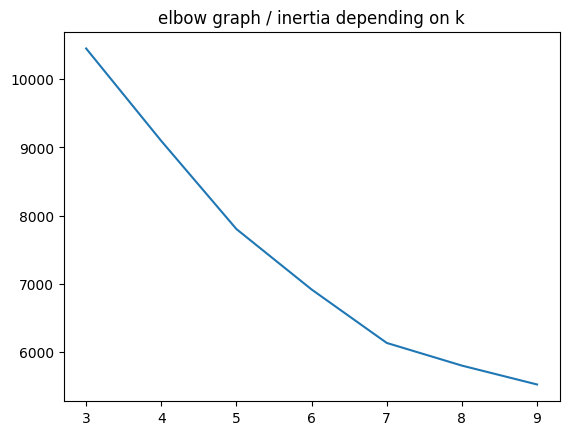

k = 3, Silhouette Score = 0.197
k = 4, Silhouette Score = 0.221
k = 5, Silhouette Score = 0.249
k = 6, Silhouette Score = 0.241
k = 7, Silhouette Score = 0.217
k = 8, Silhouette Score = 0.245
k = 9, Silhouette Score = 0.206


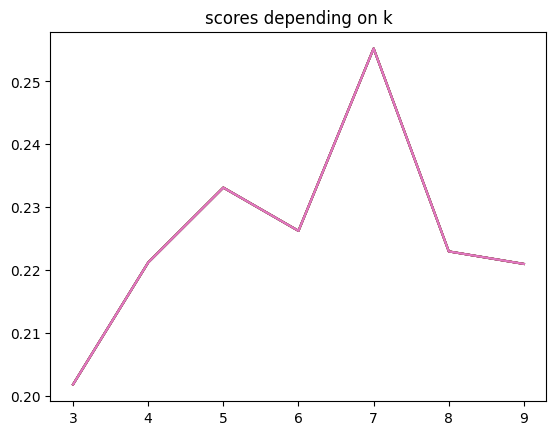

In [50]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()


In [51]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=4).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(4):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   223.000000  223.000000  223.000000  223.000000  223.000000   
mean      0.054611    0.117497   -0.125701   -0.153616   -0.008282   
std       0.978852    1.028642    1.043688    1.019942    1.018364   
min      -1.156542   -2.514534   -1.592797   -2.036702   -1.985698   
25%      -0.816402   -0.494076   -0.353546   -1.123815   -0.767988   
50%      -0.184715   -0.224682   -0.353546   -0.210927   -0.099441   
75%       0.544156    0.852895    0.885705    0.701960    0.712366   
max       3.054710    2.738655    2.124956    2.527735    2.288226   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count         2.230000e+02         2.230000e+02           2.230000e+02   
mean         -5.336323e-01        -4.484305e-01          -5.426009e-01   
std           5.089194e-01         5.074089e-01           4.993026e-01   
min          -1.000000e+00        -1.000000e+00          -

In [52]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   149.000000  149.000000  149.000000  149.000000  149.000000   
mean      0.057916    0.020123   -0.004227    0.052524   -0.030055   
std       1.080690    0.983255    1.049569    0.997172    1.001807   
min      -1.221331   -1.841048   -1.592797   -2.036702   -1.780359   
25%      -0.832600   -0.494076   -0.353546   -1.123815   -0.767988   
50%      -0.184715   -0.494076   -0.353546   -0.210927   -0.099441   
75%       0.463170    0.852895    0.885705    0.701960    0.616859   
max       3.054710    2.873353    2.124956    3.440622    2.192719   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count         1.490000e+02         1.490000e+02           1.490000e+02   
mean          9.865772e-01        -1.342282e-02           9.798658e-01   
std           1.154648e-01         1.154648e-01           1.409331e-01   
min           1.224647e-16        -1.000000e+00           

In [54]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X_scaled.shape)
print("Unique cluster labels:", np.unique(X_scaled['Label']))
print("Number of duplicates:", vietnam_housing_clean.duplicated().sum())


KMeans n_clusters: 5
Shape of X_scaled: (1346, 11)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## DBSCAN

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [58]:
df = vietnam_housing_clean.copy()
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df = df.rename(columns={'Access Road':'Access_Road'})
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df.rename(columns={'Access Road':'Access_Road'}, inplace=True)

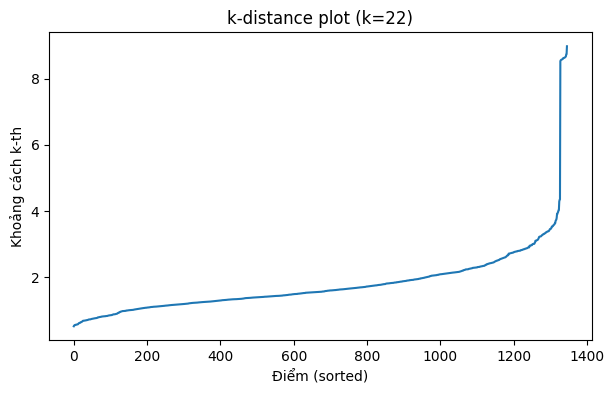

In [61]:
k = max(5, 2*X_scaled.shape[1])  # rule of thumb
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dist, _ = nbrs.kneighbors(X_scaled)
kdist = np.sort(dist[:, -1])

plt.figure(figsize=(7,4))
plt.plot(kdist); plt.title(f'k-distance plot (k={k})')
plt.xlabel('Điểm (sorted)'); plt.ylabel('Khoảng cách k-th'); plt.show()


In [62]:
for eps_test in [1.2, 1.5, 1.8, 2.0, 2.3, 2.5]:
    db = DBSCAN(eps=eps_test, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = (labels == -1).mean()
    print(f"eps={eps_test}: cụm={n_clusters}, noise={noise:.2%}")


eps=1.2: cụm=6, noise=45.47%
eps=1.5: cụm=5, noise=20.21%
eps=1.8: cụm=3, noise=9.06%
eps=2.0: cụm=2, noise=4.83%
eps=2.3: cụm=1, noise=1.26%
eps=2.5: cụm=1, noise=0.37%


In [63]:
# DBSCAN với eps = 1.5
db = DBSCAN(eps=1.5, min_samples=10).fit(X_scaled)
df['db'] = db.labels_

# K-Means để so sánh
km = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
df['km'] = km.labels_

# Chỉ tính Silhouette nếu DBSCAN ra >=2 cụm khác nhau (bỏ noise -1)
mask = df['db'] != -1
n_clusters_db = len(set(df['db'][mask]))

if n_clusters_db > 1:
    print("Silhouette DBSCAN:", silhouette_score(X[mask], df['db'][mask]))
else:
    print("DBSCAN chỉ có 1 cụm hợp lệ → không tính được Silhouette")

print("Silhouette KMeans:", silhouette_score(X, df['km']))


Silhouette DBSCAN: 0.13708533759085306
Silhouette KMeans: 0.22498044703569403


## Hierarchical clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as pl

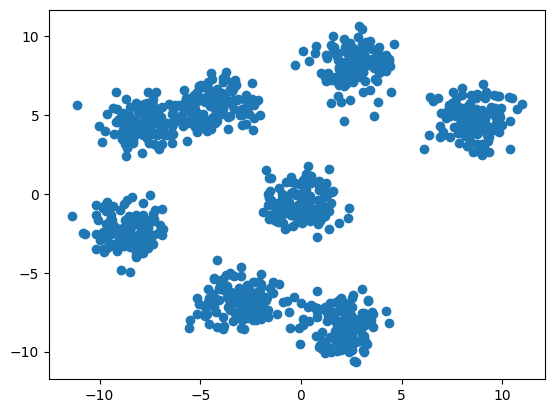

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
# Generate a random cluster dataset to experiment on. 
# X = coordinate points, y = cluster labels (not needed)
X, y = make_blobs(n_samples=1000, centers=8, n_features=2,
random_state=800)
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.show()

In [ ]:
# Generate distance matrix with 'linkage' function
distances = linkage(X_scaled, method="centroid", metric="euclidean")
print(distances)

[[5.72000000e+02 7.62000000e+02 7.69412624e-03 2.00000000e+00]
 [3.00000000e+01 1.96000000e+02 8.87881891e-03 2.00000000e+00]
 [5.91000000e+02 8.70000000e+02 1.07476240e-02 2.00000000e+00]
 ...
 [1.98900000e+03 1.99200000e+03 7.81168528e+00 3.75000000e+02]
 [1.99500000e+03 1.99600000e+03 1.02408477e+01 7.50000000e+02]
 [1.99400000e+03 1.99700000e+03 1.20025814e+01 1.00000000e+03]]


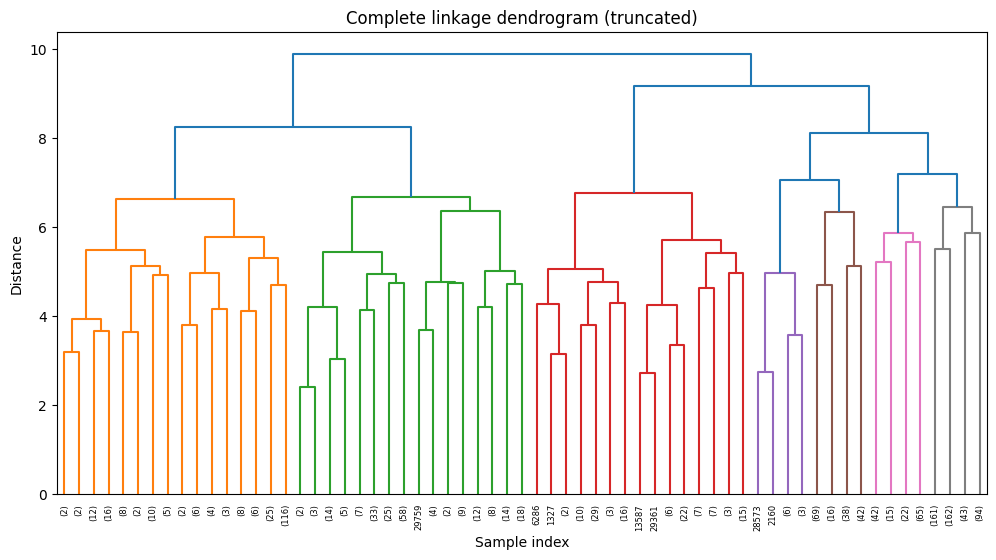

In [91]:
# select numeric columns only (or list the feature column names you want)
numeric_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
X_hier = vietnam_housing_clean[numeric_cols].dropna()

if X_hier.shape[0] < 2 or X_hier.shape[1] < 1:
    raise ValueError("Not enough numeric rows/columns for hierarchical clustering. Check vietnam_housing_clean.")

# convert to numpy array (float) for linkage
X_vals = X_hier.values.astype(float)

complete_clustering = linkage(X_vals, method="complete", metric="euclidean")
average_clustering  = linkage(X_vals, method="average",  metric="euclidean")
single_clustering   = linkage(X_vals, method="single",   metric="euclidean")

# optional: plot a truncated dendrogram for the complete linkage
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering, truncate_mode='level', p=5, labels=X_hier.index)
plt.title("Complete linkage dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

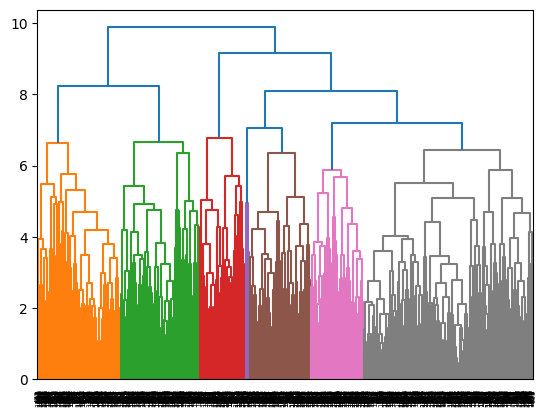

In [92]:
dendrogram(complete_clustering)
plt.show()

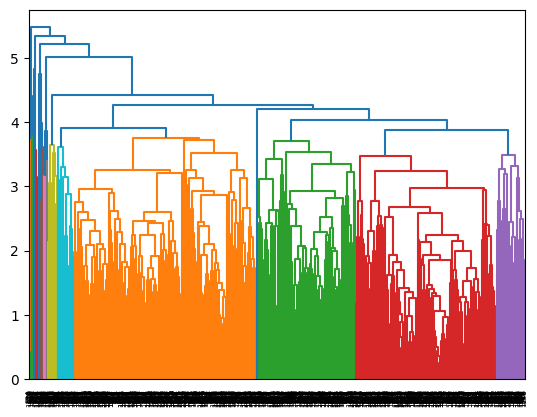

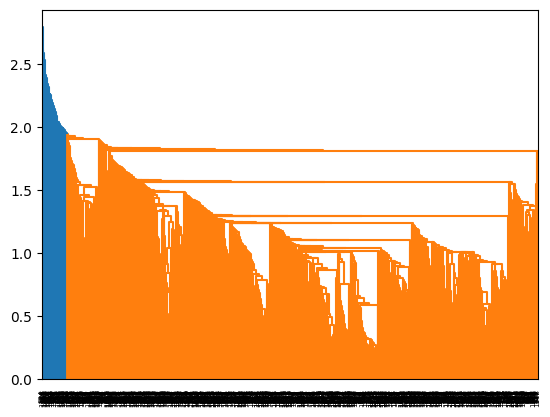

In [93]:
dendrogram(average_clustering)
plt.show()
dendrogram(single_clustering)
plt.show()

best_k=2, silhouette=0.1448


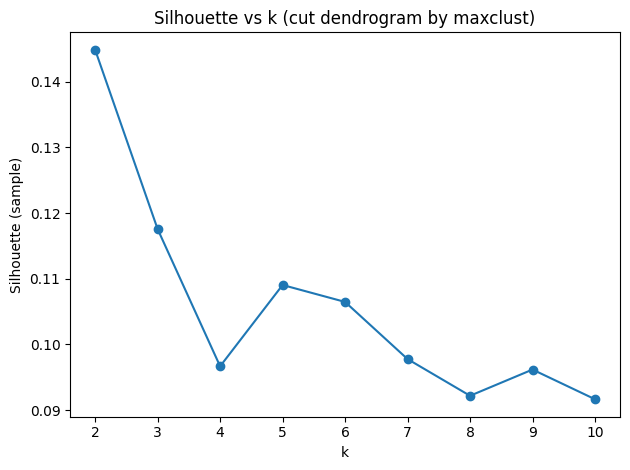

In [96]:
# Giả sử `X_hier` là DataFrame
n = len(X_hier)

# Chọn một mẫu ngẫu nhiên (số điểm không quá 2000)
idx = np.random.default_rng(42).choice(n, size=min(2000, n), replace=False)

# Trích xuất mẫu ngẫu nhiên từ X_hier bằng iloc
X_s = X_hier.iloc[idx]  # Sử dụng iloc để trích xuất các hàng theo chỉ số

# Tạo dải giá trị k từ 2 đến 10
k_grid = range(2, 11)

# Tính silhouette score cho mỗi k
sil_scores = [silhouette_score(X_s, fcluster(Z, t=k, criterion="maxclust")[idx]) for k in k_grid]

# Lấy k tối ưu
best_k = list(k_grid)[int(np.nanargmax(sil_scores))]

# In ra kết quả
print(f"best_k={best_k}, silhouette={np.nanmax(sil_scores):.4f}")

# Vẽ đồ thị silhouette score theo k
import matplotlib.pyplot as plt
plt.plot(list(k_grid), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (sample)")
plt.title("Silhouette vs k (cut dendrogram by maxclust)")
plt.tight_layout()
plt.show()


In [106]:
# Kiểm tra lại X_s và mask
print(X_s.iloc[mask].shape)  # Kiểm tra số cột sau khi áp dụng mask

# Tóm tắt cụm
summary_rows = []
for c in sorted(np.unique(labels)):
    mask = (labels_ser.values == c)
    
    # Lấy median của các cột số trong X_s
    row = {"Cluster": int(c), "Count": int(mask.sum())}
    
    # Sử dụng iloc thay vì values để giữ lại cột
    row.update(X_s.iloc[mask][numeric_cols].median().to_dict())
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values("Cluster").reset_index(drop=True)

# Hiển thị kết quả
from IPython.display import display
display(summary_df)


(442, 10)


,Cluster,Count,Area,Frontage,Bedrooms,Bathrooms,Price,House_direction_sin,House_direction_cos,Balcony_direction_sin,Balcony_direction_cos
0,1,442,-0.115645,-0.278561,-0.353546,-0.210927,-0.099441,0.0,1.0,0.0,1.0
1,2,904,-0.170807,-0.494076,-0.353546,-0.210927,-0.154358,0.0,1.0,0.0,1.0


/tmp/ipykernel_65744/3459741769.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")


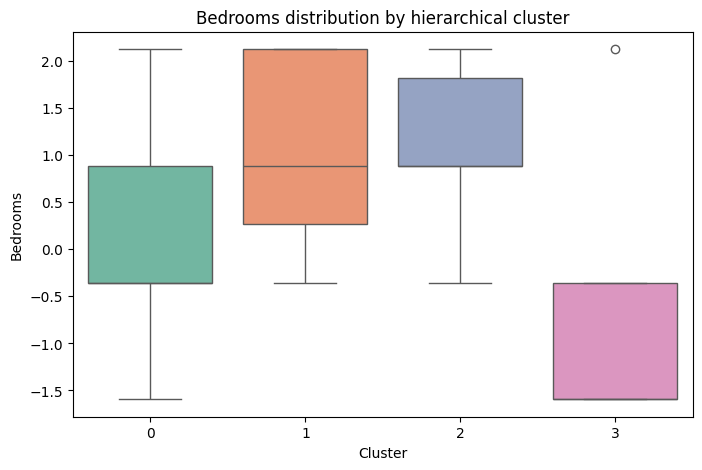

In [116]:
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
import matplotlib.pyplot as plt
# Cắt cây dendrogram thành 2 cụm (đổi số nếu muốn)
cluster_labels = cut_tree(average_clustering, n_clusters=4).reshape(-1, )

# Gắn nhãn cụm vào dataframe đang dùng (X_hier hoặc vietnam_housing_scaled)
df_cluster = X_hier.copy()
df_cluster["Cluster"] = cluster_labels

# Chọn biến để xem ý nghĩa (ví dụ 'Price')
target = "Bedrooms"

# Vẽ boxplot để so sánh phân bố biến theo cụm
plt.figure(figsize=(8,5))
sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")
plt.title(f"{target} distribution by hierarchical cluster")
plt.show()

In [117]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
# 1. Chuẩn hóa
X = vietnam_housing_clean[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
# 2. Linkage
Z = linkage(X_scaled, method='ward')
# 3. Cắt cụm (ví dụ 4 cụm)
labels = fcluster(Z, t=2, criterion='maxclust')
# 4. Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("✅ Silhouette Score:", sil_score)

✅ Silhouette Score: 0.30445706644855736


In [118]:
for k in range(3, 7):
    labels_hier = fcluster(Z, t=k, criterion='maxclust')
    silhouette = silhouette_score(X_scaled, labels_hier)
    print(f"Silhouette Score for k={k}: {silhouette:.4f}")


Silhouette Score for k=3: 0.3200
Silhouette Score for k=4: 0.2168
Silhouette Score for k=5: 0.2453
Silhouette Score for k=6: 0.2118


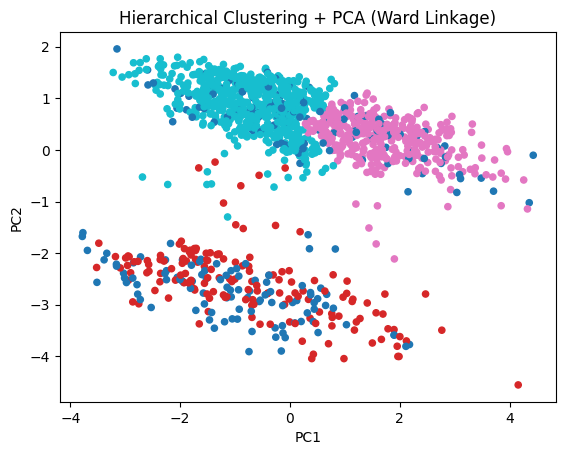

In [119]:
from sklearn.decomposition import PCA

# Chọn số lượng thành phần PCA nhỏ hơn hoặc bằng số đặc trưng trong dữ liệu (ở đây là 5)
pca = PCA(n_components=3)  # Hoặc có thể chọn n_components=2 để giảm xuống 2 chiều
X_reduced = pca.fit_transform(X_scaled)

# Tiến hành phân cụm với dữ liệu giảm chiều
Z = linkage(X_reduced, method='ward')

# Cắt cụm với số cụm tùy chọn
labels_hier = fcluster(Z, t=4, criterion='maxclust')

# Hiển thị kết quả trực quan
pca = PCA(n_components=2)  # Giảm xuống 2 chiều để trực quan hóa
X_pca = pca.fit_transform(X_scaled)

# Vẽ scatter plot với các cụm khác nhau
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_hier, cmap='tab10', s=20)
plt.title("Hierarchical Clustering + PCA (Ward Linkage)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



In [113]:
import numpy as np

print("Số cụm thật sự:", len(np.unique(labels)))
print("Phân bố nhãn:", np.unique(labels, return_counts=True))


Số cụm thật sự: 2
Phân bố nhãn: (array([1, 2], dtype=int32), array([ 223, 1123]))


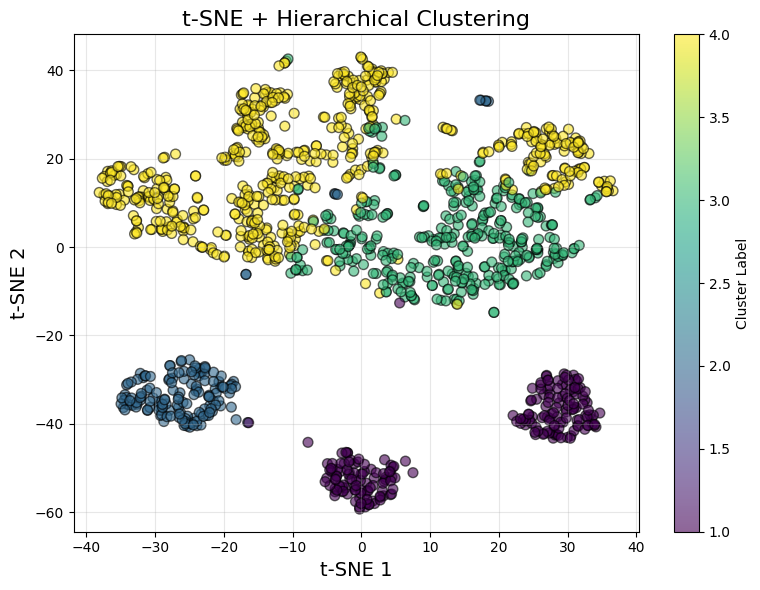

In [120]:
from sklearn.manifold import TSNE

# Áp dụng t-SNE để giảm chiều xuống 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Vẽ scatter plot sau khi giảm chiều bằng t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_hier, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.title("t-SNE + Hierarchical Clustering", fontsize=16)
plt.xlabel("t-SNE 1", fontsize=14)
plt.ylabel("t-SNE 2", fontsize=14)
plt.colorbar(label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


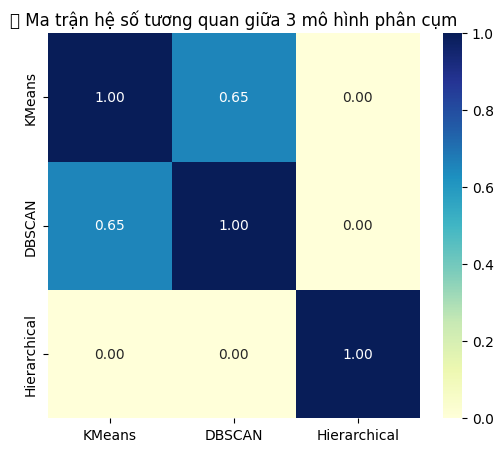

✅ Ma trận tương quan giữa các phương pháp phân cụm:


,KMeans,DBSCAN,Hierarchical
KMeans,1.000000,0.653703,0.0
DBSCAN,0.653703,1.000000,0.0
Hierarchical,0.000000,0.000000,1.0


In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Giả sử các nhãn đã có:
# df['km'] – KMeans
# df['db'] – DBSCAN
# df_cluster['Cluster'] – Hierarchical

# 1️⃣ Gộp nhãn lại thành một DataFrame chung
compare_df = pd.DataFrame({
    'KMeans': df['km'].values,
    'DBSCAN': df['db'].values,
    'Hierarchical': df_cluster['Cluster'].reindex(df.index, fill_value=-1).values
})

# 2️⃣ Đảm bảo các giá trị đều là số (tránh lỗi khi tính)
for col in compare_df.columns:
    le = LabelEncoder()
    compare_df[col] = le.fit_transform(compare_df[col])

# 3️⃣ Hàm tính Cramér’s V giữa hai phân cụm
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 4️⃣ Tạo ma trận hệ số tương quan
methods = ['KMeans', 'DBSCAN', 'Hierarchical']
coef_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)

for i in methods:
    for j in methods:
        coef_matrix.loc[i, j] = cramers_v(compare_df[i], compare_df[j])

# 5️⃣ Hiển thị ma trận
plt.figure(figsize=(6,5))
sns.heatmap(coef_matrix.astype(float), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("🔹 Ma trận hệ số tương quan giữa 3 mô hình phân cụm")
plt.show()

# 6️⃣ In kết quả chi tiết
print("✅ Ma trận tương quan giữa các phương pháp phân cụm:")
display(coef_matrix)


In [68]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Giả sử các nhãn đã có
labels_km = df['km']
labels_db = df['db']
labels_hier = df_cluster['Cluster'].reindex(df.index, fill_value=-1)  # 🔁 đồng bộ index

# Loại bỏ noise trong DBSCAN
mask = labels_db != -1

# Lọc 3 nhãn theo mask (sử dụng .loc để tránh lỗi index)
labels_db_clean = labels_db.loc[mask]
labels_km_clean = labels_km.loc[mask]
labels_hier_clean = labels_hier.loc[mask]

# ✅ Tính ARI và AMI
compare_metrics = pd.DataFrame({
    "Model Comparison": [
        "KMeans vs DBSCAN",
        "KMeans vs Hierarchical",
        "DBSCAN vs Hierarchical"
    ],
    "ARI": [
        adjusted_rand_score(labels_km_clean, labels_db_clean),
        adjusted_rand_score(labels_km, labels_hier),
        adjusted_rand_score(labels_db_clean, labels_hier_clean)
    ],
    "AMI": [
        adjusted_mutual_info_score(labels_km_clean, labels_db_clean),
        adjusted_mutual_info_score(labels_km, labels_hier),
        adjusted_mutual_info_score(labels_db_clean, labels_hier_clean)
    ]
})
print(compare_metrics)



         Model Comparison       ARI       AMI
0        KMeans vs DBSCAN  0.403670  0.685296
1  KMeans vs Hierarchical -0.005466 -0.000437
2  DBSCAN vs Hierarchical -0.025004  0.005810
